# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [1]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# tuning
import optuna

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [3]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [5]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [6]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [7]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [8]:
# 변수 세팅
def variable_setting(types, tr, te, columns_to_convert, columns_to):
    train = tr.copy()
    test = te.copy()
    
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [9]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [10]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = xgb.XGBClassifier(eval_metric='logloss', **params)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [11]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices)

        # 검증 데이터에서 예측 수행
        y_pred = model.predict(X_valid)

        # F1 점수 계산
        f1 = f1_score(y_valid, y_pred)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [12]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=12)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

## 3. Setting

In [13]:
# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

In [14]:
# drop oolumns
drop_col = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    
    # Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    # 의미를 찾을 수 없는 컬럼들 제거
    'Wip Line_Fill1', 
    'Process Desc._Fill1', 
    'Insp. Seq No._Fill1', 
    'Insp Judge Code_Fill1', 
    'Equipment_AutoClave',
    'Process Desc._AutoClave', 
    'Wip Line_AutoClave', 
    'Insp Judge Code_AutoClave',
    'Insp. Seq No._AutoClave',
    '1st Pressure Judge Value_AutoClave', 
    '2nd Pressure Judge Value_AutoClave', 
    '3rd Pressure Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'Wip Line_Fill2', 
    'Process Desc._Fill2', 
    'Insp. Seq No._Fill2', 
    'Insp Judge Code_Fill2', 
    'Wip Line_Dam', 
    'Process Desc._Dam', 
    'Insp. Seq No._Dam', 
    'Insp Judge Code_Dam',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    
    # Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    
    # 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
    'CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'CURE START POSITION Z Collect Result_Dam', # START POSITION
    'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    
    # AutoClave 의미없어보이는거 제거
    'Chamber Temp. Judge Value_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
#     '1st Pressure_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
    
    # Model.Suffix, Workorder이 같다.
    'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave',
    'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave',
    
    # 아무 의미 없는 값
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    
    # 중복 데이터 없애기
    'PalletID Collect Result_Fill1', 
    'Production Qty Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'PalletID Collect Result_Fill2', 
    'Production Qty Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'Equipment_Fill1',
    'Equipment_Fill2'
]

## 4. Matched Data

In [15]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_642/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_642/691509256.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_642/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [16]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [17]:
# 데이터 타입 변경하기
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [18]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [19]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [20]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [21]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [22]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Columns Drop

In [23]:
# 수많은 칼럼 버리기
df_train = df_train.drop(columns = drop_col, axis = 1)
df_test = df_test.drop(columns = drop_col, axis = 1)

### Type 수정

In [24]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### time 보정

In [25]:
# time 보정하기
df_train['rount_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['rount_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['rount_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['rount_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['rount_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['rount_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### target 0, 1 변환

In [26]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

## 4.5 Dam, Fill, AutoClave 단계마다 적용할 변수 기초 만들기

In [27]:
first_col = [
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'target', 'inconsistant',
    'Stage1 Line diffent Distance Speed_Dam', 'Stage1 Line Sum Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam', 'Stage2 Line Sum Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam', 'Stage3 Line Sum Speed_Dam'
]

second_col = [
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'CURE SPEED Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam',
       'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam',
       'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
       'Stage1 Circle1 Distance Speed Collect Result_Dam',
       'Stage2 Circle1 Distance Speed Collect Result_Dam',
       'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
       'THICKNESS 3 Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
       'Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
       'Head Purge Position Z Collect Result_Fill1',
       'Machine Tact time Collect Result_Fill1',
       'CURE END POSITION Z Collect Result_Fill2',
       'CURE SPEED Collect Result_Fill2',
       'CURE START POSITION Z Collect Result_Fill2',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
       'Machine Tact time Collect Result_Fill2',
       'Chamber Temp. Collect Result_AutoClave', 'inconsistant',
       'Stage1 Line diffent Distance Speed_Dam', 'Stage1 Line Sum Speed_Dam',
       'Stage2 Line diffent Distance Speed_Dam', 'Stage2 Line Sum Speed_Dam',
       'Stage3 Line diffent Distance Speed_Dam', 'Stage3 Line Sum Speed_Dam'
]

In [28]:
# Dam
first_train = df_train[first_col]
first_test = df_test[first_col]
first_train['target'] = df_train['target']

# Dam + Fill
second_train = df_train[second_col]
second_test = df_test[second_col]
second_train['target'] = df_train['target']

/tmp/ipykernel_642/908220432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target'] = df_train['target']
/tmp/ipykernel_642/908220432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['target'] = df_train['target']


## 5. 데이터 학습하기


### setting

In [29]:
# 변환 리스트
columns_to_convert = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Workorder_Dam',
    'Model.Suffix_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam'
]

In [30]:
cat_features_indices = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to

In [31]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

### Best_Params 얻기

In [32]:
# optuna tuning
cat_best_params, X_cat, y_cat, cat_train_index, cat_valid_index = catboost_optuna(cat_train, cat_features_indices)

[I 2024-08-19 07:42:56,371] A new study created in memory with name: no-name-601086b6-2161-4d09-b9ab-b40a137ddb66
[I 2024-08-19 07:43:15,490] Trial 0 finished with value: 0.14198782961460446 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.14198782961460446.
[I 2024-08-19 07:43:42,493] Trial 1 finished with value: 0.06751054852320675 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.14198782961460446.
[I 2024-08-19 07:44:54,860] Trial 2 finished with value: 0.

Best trial:
  Value: 0.14198782961460446
  Params: 
    iterations: 437
    depth: 10
    learning_rate: 0.15702970884055384
    l2_leaf_reg: 5.990598257128395
    border_count: 66
    random_strength: 1.559945204206032
    bagging_temperature: 0.05808361216819946
    od_type: IncToDec
    od_wait: 39
    boosting_type: Plain


In [33]:
# optuna tuning
lgbm_best_params, X_lgbm, y_lgbm, lgbm_train_index, lgbm_valid_index = lightgbm_optuna(lgbm_train, cat_features_indices)

[I 2024-08-19 07:47:42,431] A new study created in memory with name: no-name-03167b87-0a33-46ea-b27b-e2e7a5a64bef
[I 2024-08-19 07:47:45,147] Trial 0 finished with value: 0.06751054852320675 and parameters: {'n_estimators': 812, 'max_depth': 60, 'learning_rate': 0.0029106359131330704, 'reg_alpha': 0.24810409748678125, 'reg_lambda': 0.004207988669606638, 'min_child_weight': 1.0459808211767092, 'min_child_samples': 10, 'subsample': 0.9197056874649611, 'subsample_freq': 3, 'colsample_bytree': 0.7664580622368364, 'num_leaves': 3}. Best is trial 0 with value: 0.06751054852320675.
[I 2024-08-19 07:47:48,697] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1467, 'max_depth': 53, 'learning_rate': 0.00026587543983272726, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'min_child_weight': 1.564847850358382, 'min_child_samples': 55, 'subsample': 0.6591670111852694, 'subsample_freq': 1, 'colsample_bytree': 0.6894823157779035, 'num_leaves': 10}. Best is trial

[I 2024-08-19 07:49:05,776] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1031, 'max_depth': 37, 'learning_rate': 0.0007731789801741327, 'reg_alpha': 0.0665727866811099, 'reg_lambda': 0.002107811038076869, 'min_child_weight': 3.384158562531583, 'min_child_samples': 51, 'subsample': 0.4737211291274423, 'subsample_freq': 2, 'colsample_bytree': 0.6327373856733647, 'num_leaves': 45}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-19 07:49:11,806] Trial 19 finished with value: 0.12627291242362526 and parameters: {'n_estimators': 1253, 'max_depth': 18, 'learning_rate': 0.006310906240341599, 'reg_alpha': 0.14263748888539465, 'reg_lambda': 0.05246845012264977, 'min_child_weight': 2.5824256098171707, 'min_child_samples': 39, 'subsample': 0.41041504210346125, 'subsample_freq': 0, 'colsample_bytree': 0.33048907689085566, 'num_leaves': 55}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-19 07:49:14,694] Trial 20 finished with value: 0.02586206896551

[I 2024-08-19 07:50:40,529] Trial 36 finished with value: 0.0 and parameters: {'n_estimators': 1474, 'max_depth': 47, 'learning_rate': 0.0004291285997379904, 'reg_alpha': 0.03819882590582987, 'reg_lambda': 0.006769237481744073, 'min_child_weight': 3.5208648531974447, 'min_child_samples': 50, 'subsample': 0.43841150227105585, 'subsample_freq': 0, 'colsample_bytree': 0.30297596742929417, 'num_leaves': 59}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-19 07:50:46,391] Trial 37 finished with value: 0.12601626016260165 and parameters: {'n_estimators': 989, 'max_depth': 39, 'learning_rate': 0.00817781817039829, 'reg_alpha': 0.024972699905715056, 'reg_lambda': 0.001710485450650949, 'min_child_weight': 2.7726562013564355, 'min_child_samples': 32, 'subsample': 0.6867794893419935, 'subsample_freq': 2, 'colsample_bytree': 0.6831217179527644, 'num_leaves': 53}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-19 07:50:49,023] Trial 38 finished with value: 0.111340206185

Best trial:
  Value: 0.14056224899598393
  Params: 
    n_estimators: 1325
    max_depth: 43
    learning_rate: 0.009871149613069051
    reg_alpha: 0.028967847134875147
    reg_lambda: 0.0010048404716309263
    min_child_weight: 1.0585590904879165
    min_child_samples: 78
    subsample: 0.5695496693451576
    subsample_freq: 5
    colsample_bytree: 0.6246339245050061
    num_leaves: 61


In [34]:
# optuna tuning
xgb_best_params, X_xgb, y_xgb, xgb_train_index, xgb_valid_index = xgboost_optuna(xgb_train, cat_features_indices)

[I 2024-08-19 07:51:50,999] A new study created in memory with name: no-name-1e069554-13c4-4066-ba5e-c1a1e243dadd
[I 2024-08-19 07:51:53,797] Trial 0 finished with value: 0.13916500994035785 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.15702970884055384, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-19 07:51:58,169] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.00115279871282324, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-19 07:52:00,820] Trial 2 finished with value: 0.12678936605316973 and parameters: {'n_estimators': 374, 'max

[I 2024-08-19 07:53:14,254] Trial 22 finished with value: 0.17462482946793997 and parameters: {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.9583592856792372, 'subsample': 0.5565757572232559, 'colsample_bytree': 0.7398168219812112, 'gamma': 1.2429338669147083, 'lambda': 4.790735721814883, 'alpha': 0.05690284621926791}. Best is trial 22 with value: 0.17462482946793997.
[I 2024-08-19 07:53:19,892] Trial 23 finished with value: 0.16216216216216217 and parameters: {'n_estimators': 889, 'max_depth': 9, 'learning_rate': 0.47887947120381896, 'subsample': 0.5623100167814723, 'colsample_bytree': 0.7673890462230567, 'gamma': 1.202703167147776, 'lambda': 4.8767732776156665, 'alpha': 0.06955346650779465}. Best is trial 22 with value: 0.17462482946793997.
[I 2024-08-19 07:53:26,659] Trial 24 finished with value: 0.149812734082397 and parameters: {'n_estimators': 860, 'max_depth': 8, 'learning_rate': 0.0657265640013489, 'subsample': 0.5900564183893522, 'colsample_bytree': 0.86120382459284

[I 2024-08-19 07:55:00,039] Trial 45 finished with value: 0.1495016611295681 and parameters: {'n_estimators': 599, 'max_depth': 9, 'learning_rate': 0.6572583074757162, 'subsample': 0.7775352543850991, 'colsample_bytree': 0.7320670911528175, 'gamma': 1.0197599010734497, 'lambda': 1.5732746878741222, 'alpha': 0.02772771131917407}. Best is trial 25 with value: 0.1875.
[I 2024-08-19 07:55:04,635] Trial 46 finished with value: 0.14671814671814673 and parameters: {'n_estimators': 911, 'max_depth': 10, 'learning_rate': 0.48948343316484944, 'subsample': 0.9328264189554973, 'colsample_bytree': 0.8645801338498131, 'gamma': 1.4592331275747779, 'lambda': 1.7761384492185486, 'alpha': 0.15528219314392724}. Best is trial 25 with value: 0.1875.
[I 2024-08-19 07:55:09,703] Trial 47 finished with value: 0.13034623217922608 and parameters: {'n_estimators': 969, 'max_depth': 10, 'learning_rate': 0.08667020579620191, 'subsample': 0.8198554317075747, 'colsample_bytree': 0.7020137186958432, 'gamma': 2.403825

Best trial:
  Value: 0.1875
  Params: 
    n_estimators: 701
    max_depth: 10
    learning_rate: 0.9923011126856865
    subsample: 0.7660999617341604
    colsample_bytree: 0.7591416621317699
    gamma: 0.6327155841428214
    lambda: 0.9526097633865376
    alpha: 0.0011969062590495645


### 5-1) Dam

In [35]:
# 변환할 컬럼명 리스트
columns_to_Dam = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill1',
#     'CURE START POSITION Z Collect Result_Fill2',
#     'CURE END POSITION Z Collect Result_Fill2',
#     'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam'
]

In [36]:
cat_features_indices_Dam = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to_Dam

In [37]:
# data
cat_train_first, cat_test_first = variable_setting('catboost', first_train, first_test, columns_to_convert, columns_to_Dam)
lgbm_train_first, lgbm_test_first = variable_setting('lightgbm', first_train, first_test, columns_to_convert, columns_to_Dam)
xgb_train_first, xgb_test_first = variable_setting('xgboost', first_train, first_test, columns_to_convert, columns_to_Dam)

#### Catboost

In [38]:
# train x, y
X_cat_first = cat_train_first[cat_train_first.columns.difference(['target'])]
y_cat_first = cat_train_first['target']

In [39]:
# test x
X_test_cat_first = cat_test_first[cat_train_first.columns.difference(['target'])]

In [40]:
# 최적의 하이퍼파라미터로 모델 학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat_first, y_cat_first, cat_features=cat_features_indices_Dam)

0:	learn: 0.5204919	total: 136ms	remaining: 59.5s
1:	learn: 0.4101755	total: 183ms	remaining: 39.8s
2:	learn: 0.3430093	total: 193ms	remaining: 27.9s
3:	learn: 0.2993342	total: 218ms	remaining: 23.6s
4:	learn: 0.2694000	total: 349ms	remaining: 30.1s
5:	learn: 0.2493055	total: 433ms	remaining: 31.1s
6:	learn: 0.2378129	total: 442ms	remaining: 27.2s
7:	learn: 0.2289197	total: 539ms	remaining: 28.9s
8:	learn: 0.2234423	total: 555ms	remaining: 26.4s
9:	learn: 0.2191440	total: 655ms	remaining: 28s
10:	learn: 0.2168172	total: 665ms	remaining: 25.8s
11:	learn: 0.2139008	total: 751ms	remaining: 26.6s
12:	learn: 0.2116983	total: 803ms	remaining: 26.2s
13:	learn: 0.2097264	total: 897ms	remaining: 27.1s
14:	learn: 0.2086345	total: 1.01s	remaining: 28.3s
15:	learn: 0.2072070	total: 1.11s	remaining: 29.2s
16:	learn: 0.2067957	total: 1.13s	remaining: 27.9s
17:	learn: 0.2056056	total: 1.26s	remaining: 29.2s
18:	learn: 0.2053107	total: 1.32s	remaining: 29.1s
19:	learn: 0.2046209	total: 1.4s	remaining:

162:	learn: 0.1644894	total: 17.5s	remaining: 29.4s
163:	learn: 0.1642205	total: 17.6s	remaining: 29.4s
164:	learn: 0.1636658	total: 17.8s	remaining: 29.3s
165:	learn: 0.1636211	total: 17.9s	remaining: 29.2s
166:	learn: 0.1634557	total: 18s	remaining: 29.1s
167:	learn: 0.1631868	total: 18.1s	remaining: 29s
168:	learn: 0.1628057	total: 18.2s	remaining: 28.9s
169:	learn: 0.1625434	total: 18.4s	remaining: 28.9s
170:	learn: 0.1623330	total: 18.5s	remaining: 28.8s
171:	learn: 0.1621603	total: 18.6s	remaining: 28.7s
172:	learn: 0.1618314	total: 18.8s	remaining: 28.6s
173:	learn: 0.1617247	total: 18.9s	remaining: 28.5s
174:	learn: 0.1615976	total: 19s	remaining: 28.5s
175:	learn: 0.1611738	total: 19.1s	remaining: 28.4s
176:	learn: 0.1611487	total: 19.3s	remaining: 28.3s
177:	learn: 0.1607379	total: 19.4s	remaining: 28.2s
178:	learn: 0.1601699	total: 19.5s	remaining: 28.1s
179:	learn: 0.1601112	total: 19.6s	remaining: 28s
180:	learn: 0.1597520	total: 19.8s	remaining: 28s
181:	learn: 0.1595721	

322:	learn: 0.1273345	total: 37.4s	remaining: 13.2s
323:	learn: 0.1270156	total: 37.5s	remaining: 13.1s
324:	learn: 0.1269279	total: 37.6s	remaining: 13s
325:	learn: 0.1268884	total: 37.7s	remaining: 12.8s
326:	learn: 0.1264450	total: 37.9s	remaining: 12.7s
327:	learn: 0.1264368	total: 38s	remaining: 12.6s
328:	learn: 0.1262103	total: 38.1s	remaining: 12.5s
329:	learn: 0.1256314	total: 38.2s	remaining: 12.4s
330:	learn: 0.1255900	total: 38.3s	remaining: 12.3s
331:	learn: 0.1253443	total: 38.5s	remaining: 12.2s
332:	learn: 0.1248761	total: 38.6s	remaining: 12.1s
333:	learn: 0.1244652	total: 38.7s	remaining: 11.9s
334:	learn: 0.1243143	total: 38.8s	remaining: 11.8s
335:	learn: 0.1238527	total: 39s	remaining: 11.7s
336:	learn: 0.1234090	total: 39.1s	remaining: 11.6s
337:	learn: 0.1231205	total: 39.2s	remaining: 11.5s
338:	learn: 0.1228757	total: 39.3s	remaining: 11.4s
339:	learn: 0.1226493	total: 39.5s	remaining: 11.3s
340:	learn: 0.1225690	total: 39.6s	remaining: 11.1s
341:	learn: 0.1224

In [41]:
# 이상치를 뽑아낼 확률
cat_first_proba_train = cat_best_model.predict_proba(X_cat_first)[:, 1]
cat_first_proba_test = cat_best_model.predict_proba(X_test_cat_first)[:, 1]

#### LightGBM

In [42]:
# train x, y
X_lgbm_first = lgbm_train_first[lgbm_train_first.columns.difference(['target'])]
y_lgbm_first = lgbm_train_first['target']

In [43]:
X_test_lgbm_first = lgbm_test_first[lgbm_train_first.columns.difference(['target'])]

In [44]:
# 최적의 하이퍼파라미터로 모델 학습
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm_first, y_lgbm_first, categorical_feature=cat_features_indices_Dam)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

In [45]:
# 이상치를 뽑아낼 확률
lgbm_first_proba_train = lgbm_best_model.predict_proba(X_lgbm_first)[:, 1]
lgbm_first_proba_test = lgbm_best_model.predict_proba(X_test_lgbm_first)[:, 1]

#### XGB

In [46]:
# train x, y
X_xgb_first = xgb_train_first[xgb_train_first.columns.difference(['target'])]
y_xgb_first = xgb_train_first['target']

In [47]:
X_test_xgb_first = xgb_test_first[xgb_train_first.columns.difference(['target'])]

In [48]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb_first, y_xgb_first)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [49]:
# 이상치를 뽑아낼 확률
xgb_first_proba_train = xgb_best_model.predict_proba(X_xgb_first)[:, 1]
xgb_first_proba_test = xgb_best_model.predict_proba(X_test_xgb_first)[:, 1]

### 5-2) Dam + Fill

In [50]:
# first확률값 대입해주기
second_train['cat_proba_first'] = cat_first_proba_train
second_train['lgbm_proba_first'] = lgbm_first_proba_train
second_train['xgb_proba_first'] = xgb_first_proba_train

second_test['cat_proba_first'] = cat_first_proba_test
second_test['lgbm_proba_first'] = lgbm_first_proba_test
second_test['xgb_proba_first'] = xgb_first_proba_test

/tmp/ipykernel_642/1768494377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['cat_proba_first'] = cat_first_proba_train
/tmp/ipykernel_642/1768494377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['lgbm_proba_first'] = lgbm_first_proba_train
/tmp/ipykernel_642/1768494377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [51]:
# data
cat_train_second, cat_test_second = variable_setting('catboost', second_train, second_test, columns_to_convert, columns_to_Dam)
lgbm_train_second, lgbm_test_second = variable_setting('lightgbm', second_train, second_test, columns_to_convert, columns_to_Dam)
xgb_train_second, xgb_test_second = variable_setting('xgboost', second_train, second_test, columns_to_convert, columns_to_Dam)

#### Catboost

In [52]:
# train x, y
X_cat_second = cat_train_second[cat_train_second.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first'])]
y_cat_second = cat_train_second['target']

In [53]:
X_test_cat_second = cat_test_second[cat_train_second.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first'])]

In [54]:
# 최적의 하이퍼파라미터로 모델 학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat_second, y_cat_second, cat_features=cat_features_indices)

0:	learn: 0.5034868	total: 148ms	remaining: 1m 4s
1:	learn: 0.3779518	total: 278ms	remaining: 1m
2:	learn: 0.3110204	total: 336ms	remaining: 48.6s
3:	learn: 0.2628735	total: 416ms	remaining: 45.1s
4:	learn: 0.2335953	total: 579ms	remaining: 50s
5:	learn: 0.2172388	total: 649ms	remaining: 46.6s
6:	learn: 0.2048440	total: 728ms	remaining: 44.7s
7:	learn: 0.1945447	total: 880ms	remaining: 47.2s
8:	learn: 0.1883508	total: 919ms	remaining: 43.7s
9:	learn: 0.1842201	total: 1.11s	remaining: 47.3s
10:	learn: 0.1819791	total: 1.15s	remaining: 44.5s
11:	learn: 0.1809580	total: 1.17s	remaining: 41.5s
12:	learn: 0.1787393	total: 1.31s	remaining: 42.7s
13:	learn: 0.1777210	total: 1.49s	remaining: 44.9s
14:	learn: 0.1763671	total: 1.57s	remaining: 44.1s
15:	learn: 0.1761668	total: 1.59s	remaining: 41.7s
16:	learn: 0.1753144	total: 1.63s	remaining: 40.3s
17:	learn: 0.1746532	total: 1.78s	remaining: 41.4s
18:	learn: 0.1738736	total: 1.92s	remaining: 42.3s
19:	learn: 0.1730897	total: 2.08s	remaining: 4

162:	learn: 0.1327716	total: 22.7s	remaining: 38.2s
163:	learn: 0.1326092	total: 22.9s	remaining: 38.1s
164:	learn: 0.1324803	total: 23s	remaining: 38s
165:	learn: 0.1324382	total: 23.2s	remaining: 37.9s
166:	learn: 0.1322639	total: 23.3s	remaining: 37.7s
167:	learn: 0.1320135	total: 23.5s	remaining: 37.6s
168:	learn: 0.1319481	total: 23.7s	remaining: 37.5s
169:	learn: 0.1312276	total: 23.8s	remaining: 37.4s
170:	learn: 0.1310897	total: 24s	remaining: 37.3s
171:	learn: 0.1310158	total: 24.1s	remaining: 37.2s
172:	learn: 0.1309082	total: 24.3s	remaining: 37s
173:	learn: 0.1307870	total: 24.4s	remaining: 36.9s
174:	learn: 0.1307342	total: 24.6s	remaining: 36.8s
175:	learn: 0.1304485	total: 24.7s	remaining: 36.7s
176:	learn: 0.1303965	total: 24.9s	remaining: 36.6s
177:	learn: 0.1301889	total: 25.1s	remaining: 36.5s
178:	learn: 0.1300585	total: 25.3s	remaining: 36.4s
179:	learn: 0.1299639	total: 25.4s	remaining: 36.3s
180:	learn: 0.1297812	total: 25.6s	remaining: 36.2s
181:	learn: 0.129746

322:	learn: 0.0990996	total: 47.6s	remaining: 16.8s
323:	learn: 0.0987671	total: 47.8s	remaining: 16.7s
324:	learn: 0.0987401	total: 47.9s	remaining: 16.5s
325:	learn: 0.0986896	total: 48.1s	remaining: 16.4s
326:	learn: 0.0983944	total: 48.2s	remaining: 16.2s
327:	learn: 0.0983031	total: 48.4s	remaining: 16.1s
328:	learn: 0.0982624	total: 48.6s	remaining: 15.9s
329:	learn: 0.0980225	total: 48.7s	remaining: 15.8s
330:	learn: 0.0979833	total: 48.8s	remaining: 15.6s
331:	learn: 0.0979604	total: 49s	remaining: 15.5s
332:	learn: 0.0978601	total: 49.2s	remaining: 15.4s
333:	learn: 0.0972484	total: 49.3s	remaining: 15.2s
334:	learn: 0.0970244	total: 49.5s	remaining: 15.1s
335:	learn: 0.0968689	total: 49.6s	remaining: 14.9s
336:	learn: 0.0967861	total: 49.8s	remaining: 14.8s
337:	learn: 0.0967728	total: 49.9s	remaining: 14.6s
338:	learn: 0.0965047	total: 50.1s	remaining: 14.5s
339:	learn: 0.0964303	total: 50.2s	remaining: 14.3s
340:	learn: 0.0960243	total: 50.4s	remaining: 14.2s
341:	learn: 0.

In [55]:
# 이상치를 뽑아낼 확률
cat_second_proba_train = cat_best_model.predict_proba(X_cat_second)[:, 1]
cat_second_proba_test = cat_best_model.predict_proba(X_test_cat_second)[:, 1]

#### LightGBM

In [56]:
# train x, y
X_lgbm_second = lgbm_train_second[lgbm_train_second.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first'])]
y_lgbm_second = lgbm_train_second['target']

In [57]:
X_test_lgbm_second = lgbm_test_second[lgbm_train_second.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first'])]

In [58]:
# 최적의 하이퍼파라미터로 모델 학습
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm_second, y_lgbm_second, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

In [59]:
# 이상치를 뽑아낼 확률
lgbm_second_proba_train = lgbm_best_model.predict_proba(X_lgbm_second)[:, 1]
lgbm_second_proba_test = lgbm_best_model.predict_proba(X_test_lgbm_second)[:, 1]

#### XGB

In [60]:
# train x, y
X_xgb_second = xgb_train_second[xgb_train_second.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first'])]
y_xgb_second = xgb_train_second['target']

In [61]:
X_test_xgb_second = xgb_test_second[xgb_train_second.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first'])]

In [62]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb_second, y_xgb_second)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [63]:
# 이상치를 뽑아낼 확률
xgb_second_proba_train = xgb_best_model.predict_proba(X_xgb_second)[:, 1]
xgb_second_proba_test = xgb_best_model.predict_proba(X_test_xgb_second)[:, 1]

### 5-3) AutoClave(ALL)

In [64]:
# first, second확률값 대입해주기
X_cat['cat_proba_first'] = cat_first_proba_train
# X_cat['lgbm_proba_first'] = lgbm_first_proba_train
# X_cat['xgb_proba_first'] = xgb_first_proba_train

X_cat['cat_proba_second'] = cat_second_proba_train
# X_cat['lgbm_proba_second'] = lgbm_second_proba_train
# X_cat['xgb_proba_second'] = xgb_second_proba_train

In [65]:
# first, second 확률값 대입해주기
# X_lgbm['cat_proba_first'] = cat_first_proba_train
X_lgbm['lgbm_proba_first'] = lgbm_first_proba_train
# X_lgbm['xgb_proba_first'] = xgb_first_proba_train

# X_lgbm['cat_proba_second'] = cat_second_proba_train
X_lgbm['lgbm_proba_second'] = lgbm_second_proba_train
# X_lgbm['xgb_proba_second'] = xgb_second_proba_train

In [66]:
# first, second 확률값 대입해주기
# X_xgb['cat_proba_first'] = cat_first_proba_train
# X_xgb['lgbm_proba_first'] = lgbm_first_proba_train
X_xgb['xgb_proba_first'] = xgb_first_proba_train

# X_xgb['cat_proba_second'] = cat_second_proba_train
# X_xgb['lgbm_proba_second'] = lgbm_second_proba_train
X_xgb['xgb_proba_second'] = xgb_second_proba_train

In [67]:
# train을 train, valid로 분리해주기
X_train_cat = X_cat.loc[cat_train_index, :]
y_train_cat = y_cat.loc[cat_train_index]

X_valid_cat = X_cat.loc[cat_valid_index, :]
y_valid_cat = y_cat.loc[cat_valid_index]

In [68]:
# train을 train, valid로 분리해주기
X_train_lgbm = X_lgbm.loc[lgbm_train_index, :]
y_train_lgbm = y_lgbm.loc[lgbm_train_index]

X_valid_lgbm = X_lgbm.loc[lgbm_valid_index, :]
y_valid_lgbm = y_lgbm.loc[lgbm_valid_index]

In [69]:
# train을 train, valid로 분리해주기
X_train_xgb = X_xgb.loc[xgb_train_index, :]
y_train_xgb = y_xgb.loc[xgb_train_index]

X_valid_xgb = X_xgb.loc[xgb_valid_index, :]
y_valid_xgb = y_xgb.loc[xgb_valid_index]

#### Catboost

In [70]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)

0:	learn: 0.4722793	total: 68.9ms	remaining: 30.1s
1:	learn: 0.3631366	total: 104ms	remaining: 22.7s
2:	learn: 0.2835003	total: 226ms	remaining: 32.7s
3:	learn: 0.2378105	total: 312ms	remaining: 33.7s
4:	learn: 0.2083955	total: 352ms	remaining: 30.4s
5:	learn: 0.1840780	total: 452ms	remaining: 32.5s
6:	learn: 0.1748481	total: 468ms	remaining: 28.7s
7:	learn: 0.1654039	total: 584ms	remaining: 31.3s
8:	learn: 0.1583675	total: 663ms	remaining: 31.5s
9:	learn: 0.1517897	total: 777ms	remaining: 33.2s
10:	learn: 0.1501031	total: 801ms	remaining: 31s
11:	learn: 0.1486898	total: 856ms	remaining: 30.3s
12:	learn: 0.1454037	total: 983ms	remaining: 32.1s
13:	learn: 0.1440288	total: 1.13s	remaining: 34.2s
14:	learn: 0.1424181	total: 1.27s	remaining: 35.8s
15:	learn: 0.1411602	total: 1.41s	remaining: 37.1s
16:	learn: 0.1404400	total: 1.51s	remaining: 37.3s
17:	learn: 0.1396403	total: 1.54s	remaining: 35.9s
18:	learn: 0.1396149	total: 1.55s	remaining: 34.1s
19:	learn: 0.1390160	total: 1.69s	remainin

162:	learn: 0.0900812	total: 18.6s	remaining: 31.2s
163:	learn: 0.0899072	total: 18.7s	remaining: 31.1s
164:	learn: 0.0898959	total: 18.8s	remaining: 31s
165:	learn: 0.0897877	total: 18.9s	remaining: 30.9s
166:	learn: 0.0897776	total: 19.1s	remaining: 30.8s
167:	learn: 0.0896901	total: 19.2s	remaining: 30.8s
168:	learn: 0.0894812	total: 19.4s	remaining: 30.7s
169:	learn: 0.0893957	total: 19.5s	remaining: 30.6s
170:	learn: 0.0892902	total: 19.6s	remaining: 30.5s
171:	learn: 0.0890784	total: 19.8s	remaining: 30.4s
172:	learn: 0.0885988	total: 19.9s	remaining: 30.3s
173:	learn: 0.0882360	total: 20s	remaining: 30.2s
174:	learn: 0.0881580	total: 20.1s	remaining: 30.1s
175:	learn: 0.0881394	total: 20.3s	remaining: 30.1s
176:	learn: 0.0875890	total: 20.4s	remaining: 30s
177:	learn: 0.0874150	total: 20.5s	remaining: 29.9s
178:	learn: 0.0869539	total: 20.7s	remaining: 29.8s
179:	learn: 0.0869464	total: 20.8s	remaining: 29.7s
180:	learn: 0.0867870	total: 20.9s	remaining: 29.6s
181:	learn: 0.0865

321:	learn: 0.0652631	total: 39.8s	remaining: 14.2s
322:	learn: 0.0651563	total: 40s	remaining: 14.1s
323:	learn: 0.0651465	total: 40.1s	remaining: 14s
324:	learn: 0.0649472	total: 40.2s	remaining: 13.9s
325:	learn: 0.0649415	total: 40.4s	remaining: 13.7s
326:	learn: 0.0648966	total: 40.5s	remaining: 13.6s
327:	learn: 0.0645718	total: 40.6s	remaining: 13.5s
328:	learn: 0.0642244	total: 40.8s	remaining: 13.4s
329:	learn: 0.0639822	total: 40.9s	remaining: 13.3s
330:	learn: 0.0639183	total: 41s	remaining: 13.1s
331:	learn: 0.0638670	total: 41.2s	remaining: 13s
332:	learn: 0.0637710	total: 41.3s	remaining: 12.9s
333:	learn: 0.0637279	total: 41.4s	remaining: 12.8s
334:	learn: 0.0632274	total: 41.5s	remaining: 12.6s
335:	learn: 0.0631122	total: 41.7s	remaining: 12.5s
336:	learn: 0.0627432	total: 41.8s	remaining: 12.4s
337:	learn: 0.0627158	total: 41.9s	remaining: 12.3s
338:	learn: 0.0625029	total: 42s	remaining: 12.1s
339:	learn: 0.0624289	total: 42.1s	remaining: 12s
340:	learn: 0.0622031	to

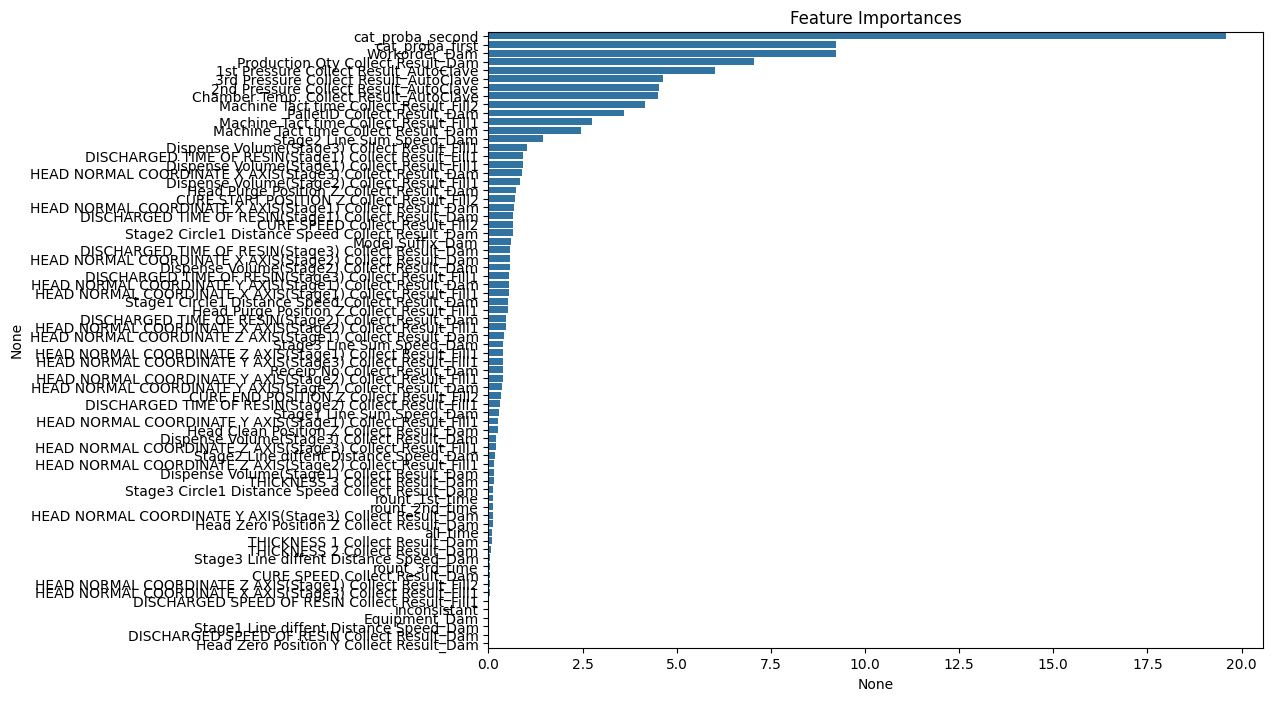

In [71]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [72]:
# valid 확인하기
pred = cat_best_model.predict(X_valid_cat)
get_clf_eval(y_valid_cat, pred)

오차행렬:
 [[ 152  306]
 [  71 7573]]

정확도: 0.9535
정밀도: 0.6816
재현율: 0.3319
F1: 0.4464


In [73]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_cat, y_pred_custom_threshold_cat = model_best_threshold(cat_best_model, X_valid_cat, y_valid_cat)
get_clf_eval(y_valid_cat, y_pred_custom_threshold_cat)

오차행렬:
 [[ 204  254]
 [ 175 7469]]

정확도: 0.9471
정밀도: 0.5383
재현율: 0.4454
F1: 0.4875


In [74]:
# tmp
proba1 = cat_best_model.predict_proba(X_cat)[:, 1]

#### LGBM

In [75]:
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train_lgbm, y_train_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

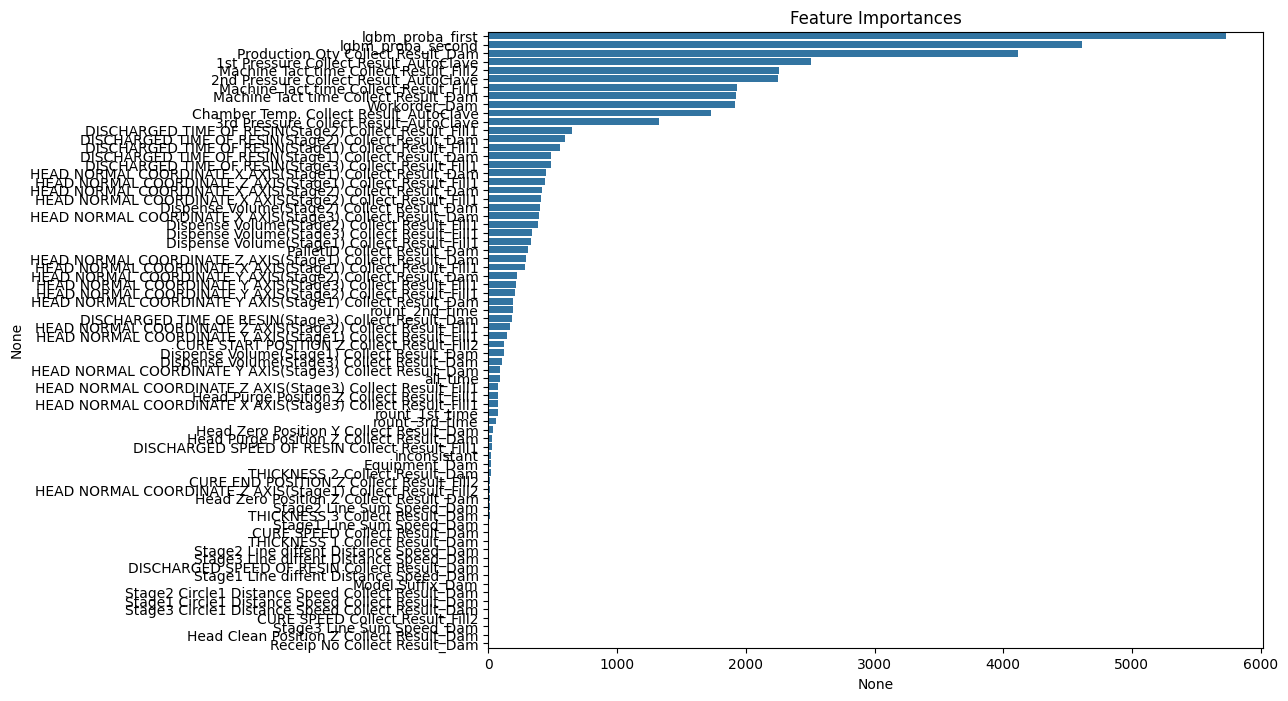

In [76]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [77]:
pred = lgbm_best_model.predict(X_valid_lgbm)
get_clf_eval(y_valid_lgbm, pred)

오차행렬:
 [[ 423   35]
 [  29 7615]]

정확도: 0.9921
정밀도: 0.9358
재현율: 0.9236
F1: 0.9297


In [78]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_lgbm, y_pred_custom_threshold_lgbm = model_best_threshold(lgbm_best_model, X_valid_lgbm, y_valid_lgbm)
get_clf_eval(y_valid_lgbm, y_pred_custom_threshold_lgbm)

오차행렬:
 [[ 420   38]
 [  22 7622]]

정확도: 0.9926
정밀도: 0.9502
재현율: 0.9170
F1: 0.9333


In [79]:
proba2 = lgbm_best_model.predict_proba(X_lgbm)[:, 1]

#### XGB

In [80]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

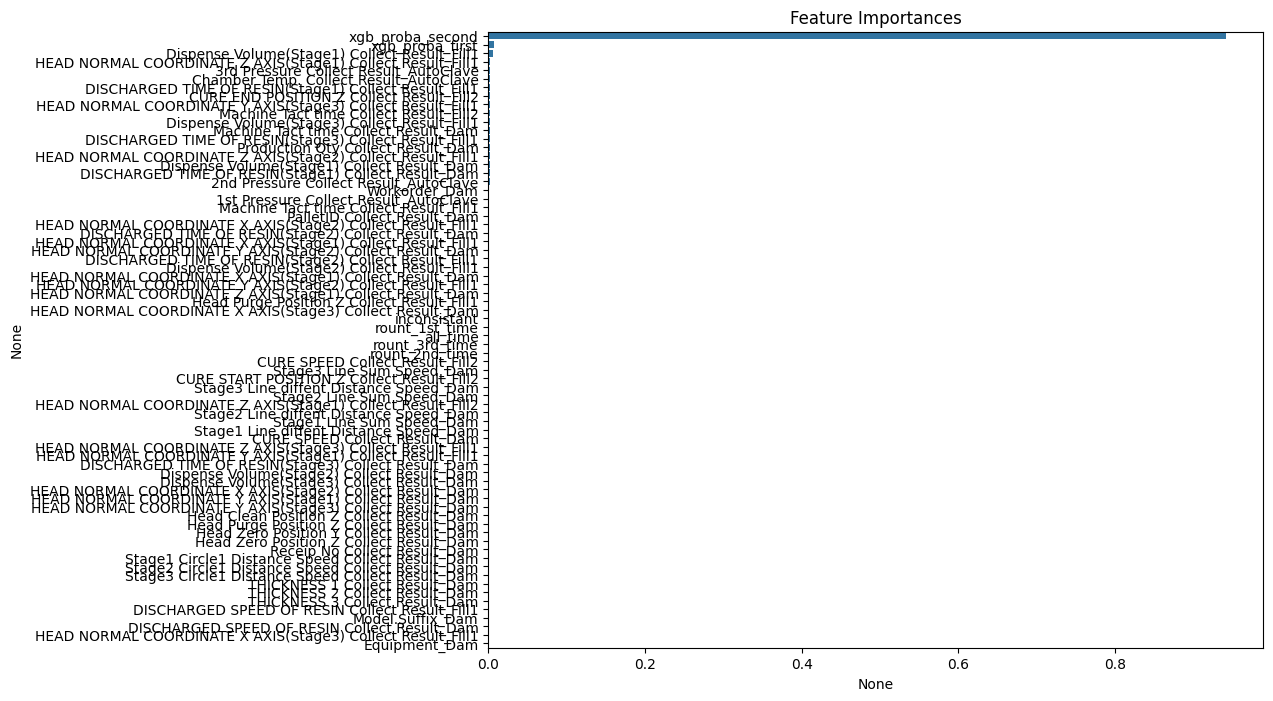

In [81]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [82]:
pred = xgb_best_model.predict(X_valid_xgb)
get_clf_eval(y_valid_xgb, pred)

오차행렬:
 [[ 454    4]
 [  12 7632]]

정확도: 0.9980
정밀도: 0.9742
재현율: 0.9913
F1: 0.9827


In [83]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_xgb, y_pred_custom_threshold_xgb = model_best_threshold(xgb_best_model, X_valid_xgb, y_valid_xgb)
get_clf_eval(y_valid_xgb, y_pred_custom_threshold_xgb)

오차행렬:
 [[ 452    6]
 [   4 7640]]

정확도: 0.9988
정밀도: 0.9912
재현율: 0.9869
F1: 0.9891


In [84]:
proba3 = xgb_best_model.predict_proba(X_xgb)[:, 1]

## 6. Inference

In [85]:
set_id = pd.read_csv(load_dir + 'test.csv')
cat_test = pd.concat([cat_test, set_id['Set ID']], axis = 1)
xgb_test = pd.concat([xgb_test, set_id['Set ID']], axis = 1)
lgbm_test = pd.concat([lgbm_test, set_id['Set ID']], axis = 1)

In [86]:
# first, second 확률값 넣어주기
cat_test['cat_proba_first'] = cat_first_proba_test
# cat_test['lgbm_proba_first'] = lgbm_first_proba_test
# cat_test['xgb_proba_first'] = xgb_first_proba_test

cat_test['cat_proba_second'] = cat_second_proba_test
# cat_test['lgbm_proba_second'] = lgbm_second_proba_test
# cat_test['xgb_proba_second'] = xgb_second_proba_test

In [87]:
# first, second 확률값 넣어주기
# xgb_test['cat_proba_first'] = cat_first_proba_test
# xgb_test['lgbm_proba_first'] = lgbm_first_proba_test
xgb_test['xgb_proba_first'] = xgb_first_proba_test

# xgb_test['cat_proba_second'] = cat_second_proba_test
# xgb_test['lgbm_proba_second'] = lgbm_second_proba_test
xgb_test['xgb_proba_second'] = xgb_second_proba_test

In [88]:
# first, second 확률값 넣어주기
# lgbm_test['cat_proba_first'] = cat_first_proba_test
lgbm_test['lgbm_proba_first'] = lgbm_first_proba_test
# lgbm_test['xgb_proba_first'] = xgb_first_proba_test

# lgbm_test['cat_proba_second'] = cat_second_proba_test
lgbm_test['lgbm_proba_second'] = lgbm_second_proba_test
# lgbm_test['xgb_proba_second'] = xgb_second_proba_test

### Catboost

In [89]:
# test pool# test pool
cat_test_pool = Pool(data=cat_test.drop(columns='Set ID'), cat_features=cat_features_indices)

In [90]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat, y_cat, cat_features=cat_features_indices)

0:	learn: 0.5234552	total: 14.3ms	remaining: 6.21s
1:	learn: 0.3865966	total: 49.1ms	remaining: 10.7s
2:	learn: 0.3043544	total: 106ms	remaining: 15.3s
3:	learn: 0.2551399	total: 241ms	remaining: 26.1s
4:	learn: 0.2177744	total: 293ms	remaining: 25.3s
5:	learn: 0.1921275	total: 359ms	remaining: 25.8s
6:	learn: 0.1773005	total: 480ms	remaining: 29.5s
7:	learn: 0.1659120	total: 652ms	remaining: 35s
8:	learn: 0.1576074	total: 793ms	remaining: 37.7s
9:	learn: 0.1527606	total: 921ms	remaining: 39.3s
10:	learn: 0.1496163	total: 1.06s	remaining: 41s
11:	learn: 0.1479084	total: 1.14s	remaining: 40.3s
12:	learn: 0.1452013	total: 1.29s	remaining: 42.2s
13:	learn: 0.1435621	total: 1.45s	remaining: 43.9s
14:	learn: 0.1427638	total: 1.61s	remaining: 45.4s
15:	learn: 0.1415797	total: 1.75s	remaining: 46.1s
16:	learn: 0.1404966	total: 1.92s	remaining: 47.4s
17:	learn: 0.1400522	total: 1.99s	remaining: 46.3s
18:	learn: 0.1395972	total: 2.17s	remaining: 47.8s
19:	learn: 0.1389366	total: 2.32s	remaining

162:	learn: 0.0979452	total: 22.5s	remaining: 37.9s
163:	learn: 0.0978393	total: 22.7s	remaining: 37.8s
164:	learn: 0.0976792	total: 22.9s	remaining: 37.7s
165:	learn: 0.0968164	total: 23s	remaining: 37.6s
166:	learn: 0.0967783	total: 23.2s	remaining: 37.5s
167:	learn: 0.0967056	total: 23.3s	remaining: 37.4s
168:	learn: 0.0966365	total: 23.5s	remaining: 37.2s
169:	learn: 0.0966129	total: 23.7s	remaining: 37.1s
170:	learn: 0.0965175	total: 23.8s	remaining: 37s
171:	learn: 0.0964972	total: 24s	remaining: 36.9s
172:	learn: 0.0962092	total: 24.1s	remaining: 36.8s
173:	learn: 0.0960634	total: 24.3s	remaining: 36.7s
174:	learn: 0.0955619	total: 24.4s	remaining: 36.6s
175:	learn: 0.0953864	total: 24.6s	remaining: 36.5s
176:	learn: 0.0951183	total: 24.8s	remaining: 36.4s
177:	learn: 0.0949134	total: 24.9s	remaining: 36.2s
178:	learn: 0.0948334	total: 25.1s	remaining: 36.1s
179:	learn: 0.0943884	total: 25.2s	remaining: 36s
180:	learn: 0.0943165	total: 25.4s	remaining: 35.9s
181:	learn: 0.094231

322:	learn: 0.0675997	total: 47.7s	remaining: 16.8s
323:	learn: 0.0674892	total: 47.8s	remaining: 16.7s
324:	learn: 0.0671337	total: 48s	remaining: 16.5s
325:	learn: 0.0671053	total: 48.1s	remaining: 16.4s
326:	learn: 0.0670942	total: 48.3s	remaining: 16.3s
327:	learn: 0.0670692	total: 48.5s	remaining: 16.1s
328:	learn: 0.0670662	total: 48.6s	remaining: 16s
329:	learn: 0.0666959	total: 48.8s	remaining: 15.8s
330:	learn: 0.0665571	total: 48.9s	remaining: 15.7s
331:	learn: 0.0661902	total: 49.1s	remaining: 15.5s
332:	learn: 0.0661805	total: 49.2s	remaining: 15.4s
333:	learn: 0.0661728	total: 49.4s	remaining: 15.2s
334:	learn: 0.0661668	total: 49.6s	remaining: 15.1s
335:	learn: 0.0660896	total: 49.8s	remaining: 15s
336:	learn: 0.0660777	total: 49.9s	remaining: 14.8s
337:	learn: 0.0660402	total: 50.1s	remaining: 14.7s
338:	learn: 0.0660265	total: 50.3s	remaining: 14.5s
339:	learn: 0.0659000	total: 50.4s	remaining: 14.4s
340:	learn: 0.0657863	total: 50.5s	remaining: 14.2s
341:	learn: 0.0657

In [91]:
# pred
cat_pred = cat_best_model.predict(cat_test.drop(columns=['Set ID', 'target']))

In [92]:
np.unique(cat_pred, return_counts = True)

(array([0, 1]), array([16767,   594]))

### LGBM

In [93]:
# 최적의 하이퍼파라미터로 모델 재학습
lgbm_best_params["random_seed"] = 42
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm, y_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_seed=42,
               random_state=42, reg_alpha=0.028967847134875147,
               reg_lambda=0.0010048404716309263, subsample=0.5695496693451576,
               subsample_freq=5)

In [94]:
# pred
lgbm_pred = lgbm_best_model.predict(lgbm_test.drop(columns=['Set ID', 'target']))

In [95]:
np.unique(lgbm_pred, return_counts = True)

(array([0, 1]), array([16754,   607]))

### XGB

In [96]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_seed"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb, y_xgb)

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:59:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [97]:
# pred
xgb_pred = xgb_best_model.predict(xgb_test.drop(columns=['Set ID', 'target']))

In [98]:
np.unique(xgb_pred, return_counts = True)

(array([0, 1]), array([16561,   800]))

In [99]:
# best ensemble
best_f1 = 0
best_f1_t = 0
best_weights = None
best_weights_t = None

# 가중치 조합 테스트
for w1 in range(1, 10):
    for w2 in range(0, 10):
        for w3 in range(0, 10):
                # 가중 평균 계산
                final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3) / (w1 + w2 + w3)
                y_pred = (final_proba > 0.5).astype(int)
            
                # F1 스코어 계산
                f1 = f1_score(df_train['target'], y_pred)
                print(f1)
                
                # Threshold 스코어 계산
                precision, recall, thresholds = precision_recall_curve(df_train['target'], final_proba)
                f1_scores = 2*recall*precision / (recall + precision)
                best_threshold = thresholds[np.argmax(f1_scores)]
                y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
                f1_t = f1_score(df_train['target'], y_pred_custom_threshold)

                # 최고 성능 저장
                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = (w1, w2, w3)
                
                if f1_t > best_f1_t:
                    best_f1_t = f1_t
                    best_weights_t = (w1, w2, w3)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.6560130010834236
0.9961636828644501
0.9963883577650308
0.9963883577650308
0.9963883577650308
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.971763683753258
0.992301112061591
0.9980855137204849
0.9972369819341127
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9845824411134905
0.9910141206675225
0.9946615417467435
0.9982978723404256
0.9972369819341127
0.9972369819341127
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.9966015293118097
0.985253259243428
0.9895321512497329
0.9927350427350428
0.9959479633184048
0.9982978723404256
0.9972369819341127
0.9972369819341127
0.9970250743731407
0.9968132568514978
0.9966015293118097
0.9854824935952178
0.988677632984405
0.9901751388295601
0.9944515578318396
0.9961620469083156
0.9985109551159328
0.9974489795918366
0.9972369819341127
0.9972369819341127
0.9970250743731407
0.9859154929577465
0.9880444064901794
0.99017513882956

0.8764789398958825
0.9733014977208596
0.9869014386944385
0.9910064239828693
0.991869918699187
0.992301112061591
0.9942344650864829
0.9955195220823554
0.9965899403239556
0.9980855137204849
0.971763683753258
0.9834372983437298
0.9875536480686695
0.9912261930237536
0.991869918699187
0.992301112061591
0.9933746527035692
0.9950907150480256
0.9959479633184048
0.9965899403239556
0.9808643302515588
0.9856192315947628
0.9888650963597431
0.9905821917808219
0.991869918699187
0.9920855614973262
0.9929441949967928
0.9940222032450898
0.9953051643192489
0.9959479633184048
0.9828326180257511
0.9847802786709539
0.989090909090909
0.9905862216516902
0.9916577540106951
0.991869918699187
0.9927288280581693
0.9933746527035692
0.9948761742100769
0.9957337883959045
0.9832761578044596
0.9852216748768473
0.9878283151825752
0.9901625320786999
0.9912299465240642
0.9916577540106951
0.9925165704511438
0.9929441949967928
0.9938073884262225
0.9950907150480256
0.9834941050375134
0.985873287671233
0.9878283151825752
0.

0.9135519376289841
0.9724212812160694
0.9827808867843306
0.9864661654135338
0.988633926656659
0.990794262470563
0.9912261930237536
0.991869918699187
0.991869918699187
0.992301112061591
0.971763683753258
0.9823428079242034
0.9840928632846087
0.9864719776680266
0.9892887746358183
0.9912261930237536
0.9912261930237536
0.991869918699187
0.991869918699187
0.992301112061591
Best F1 Score:  0.9989363965113806
Best Weights:  (1, 7, 8)


In [100]:
# best ensemble 적용
cat = proba1 * 1
lgbm = proba2 * 7
xgb = proba3 * 8
y_best = (cat + lgbm + xgb)/(1 + 7 + 8)

In [102]:
precision, recall, thresholds = precision_recall_curve(df_train['target'], y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(df_train['target'], y_pred_custom_threshold)

오차행렬:
 [[ 2348     2]
 [    3 38153]]

정확도: 0.9999
정밀도: 0.9987
재현율: 0.9991
F1: 0.9989


In [103]:
# proba
xgb_proba = xgb_best_model.predict_proba(xgb_test.drop(columns=['Set ID', 'target']))[:, 1]
cat_proba = cat_best_model.predict_proba(cat_test.drop(columns=['Set ID', 'target']))[:, 1]
lgbm_proba = lgbm_best_model.predict_proba(lgbm_test.drop(columns=['Set ID', 'target']))[:, 1]

In [104]:
# 추론
cat = cat_proba * 1
lgbm = lgbm_proba * 7
xgb = xgb_proba * 8
p = (cat + lgbm + xgb)/(1 + 7 + 8)

In [105]:
p2 = np.where(p >= weights_best_threshold, 'AbNormal', 'Normal')

In [106]:
np.unique(p2, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  543, 16818]))

In [107]:
p3 = np.where(p >= 0.5, 'AbNormal', 'Normal')

In [108]:
np.unique(p3, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  685, 16676]))

## 7. Submission

In [111]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = p3

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [112]:
df_sub['target']

0          Normal
1          Normal
2        AbNormal
3          Normal
4          Normal
           ...   
17356      Normal
17357      Normal
17358      Normal
17359      Normal
17360      Normal
Name: target, Length: 17361, dtype: object

# 꼭 df_sub['target'] 확인하고 제출하시오